# Clustering with k-means for an image compression algorithm.

## Explanation for color image quantization

Color image quantization is the process of transforming an image so that it can be represented with a small subset of colors; a subset smaller than the image's original palette size. Image quantization is a form of lossy data compression since the number of bits used for the palette is reduced. During this compression some data is lost and therefore we must use a careful algorithm that will minimize the perceived difference between the original image and its quantized counterpart. Other than compression, image quantization plays an important role in image recognition algorithms.

When representing images in true color, each pixel is represented by 3 RGB components and each one of the 3 RGB components is represented by 8 bits and can take a value from 0 to 255. This means that in true color representation one can use 2^24≈16 Million different colors. In this exercise we will perform image quantization from images given in true color into 256, 16 or even less colors.

There are many algorithms for quantization. In this exercise, you are going to use K-means in color space to achieve quantization. The color (a point in RGB space) assigned to each pixel is the color of the centroid of the cluster. 

To summarize, every pixel in the image is a point in the three dimensional RGB space. We want to cluster these points into k clusters and then replace each pixel by the centroid of the cluster to which it was assigned to obtain the compressed image.

In [ ]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
# load the image and confirm skimage is imported properly.
img_path=os.getcwd()
image = io.imread('{}/small_duck.jpg'.format(img_path))
io.imshow(image)
io.show()
print(image.shape)

In [5]:
# save the dimensions of the image and reshape it for easier manipulation
rows = image.shape[0]
cols = image.shape[1]
image = image.reshape(image.shape[0]*image.shape[1],3)
print(image.shape)

(676800, 3)


## Random centroids

Each centroid is a point in RGB space (color) in the image. This function should uniformly pick `k` centroids from the dataset.
This function should take as input a single image of shape `(num_pixels, 3)` and `k`, the number of centroids. Notice we are flattening the image to a two dimensional array for easier manipulation. This function should return randomly chosen centroids of shape `(k,3)` as a numpy array. Make sure you are choosing different values.

In [7]:
def get_random_centroids(X, k):

    '''
    Each centroid is a point in RGB space (color) in the image. 
    This function should uniformly pick `k` centroids from the dataset.
    Input: a single image of shape `(num_pixels, 3)` and `k`, the number of centroids. 
    Notice we are flattening the image to a two dimentional array.
    Output: Randomly chosen centroids of shape `(k,3)` as a numpy array. 
    '''
    centroids = []
    centriods_index=[]
    segment_length = divmod(X.shape[0], k+1)[0]
    for segment in range(1,k+1):
        centroids.append(X[segment*segment_length,:])
        centriods_index.append(segment*segment_length)
    return np.asarray(centroids).astype(np.float)
k = 7 
centroids = get_random_centroids(image, k)
print(centroids)

[[ 74.  85. 151.]
 [ 89.  92. 107.]
 [ 81.  21.  13.]
 [ 17.  19.  34.]
 [ 48.  20.   0.]
 [ 65.  75. 110.]
 [195. 176. 161.]]


/var/folders/bf/rny982hd0_v_1ckvccl548yw0000gn/T/ipykernel_10399/1242999917.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.asarray(centroids).astype(np.float)


## Distance function

The Minkowski distance is a metric which can be considered as a generalization of the Euclidean and Manhattan distances. 

The Minkoski distance of order $p$ between two points: $\vec{x}=(x_1, ..., x_n)$ and $\vec{y}=(y_1, ..., y_n)$ is:
$$D(\vec{x},\vec{y}) = (\sum_{i=1}^n \mid x_i - y_i \mid ^p)^{\frac{1}{p}}$$

Inputs: 
* a single image of shape `(num_pixels, 3)`.
* the centroids `(k, 3)`.
* the distance parameter p.

Output: numpy array of shape `(k, num_pixels)` thats holds the distances of all points in RGB space from all centroids.

In [8]:

def naive_pow(n, k):
    res=n
    for i in range(1,k):
        res *= n
    return res
def lp_distance(X, centroids, p=2):

    '''
    Inputs: 
    A single image of shape (num_pixels, 3)
    The centroids (k, 3)
    The distance parameter p

    output: numpy array of shape `(k, num_pixels)` thats holds the distances of 
    all points in RGB space from all centroids
    '''

    k = len(centroids)
    n = X.shape[1]
    num_pixels=X.shape[0]
    RGB_distance=np.zeros([k,num_pixels])
    for i,c in enumerate(centroids):
        for j,x in enumerate(X):
            dist = 0
            for dim in range(n):
                dist+=naive_pow(np.abs(x[dim] - c[dim]),p)
            RGB_distance[i,j]=dist ** (1 / p)
    return RGB_distance


In [9]:
distances = lp_distance(image, centroids, 5)

In [11]:
print(distances.shape)

(7, 676800)


## Kmeans algorithm

Calculate the locally optimal centroids. At each iteration, assigning every RGB point to its closest centroid and calculating new centroids by averaging the points that were assigned to every centroid. This function stops, when no improvement was made or once max_iter iterations is reached.

Inputs:
- X: a single image of shape (num_pixels, 3).
- k: number of centroids.
- p: the parameter governing the distance measure.
- max_iter: the maximum number of iterations to perform. (default value = 100).

Outputs:
- The calculated centroids as a numpy array.
- The final assignment of all RGB points to the closest centroids as a numpy array.
"""


In [12]:
def kmeans(X, k, p=2 ,max_iter=100, centroids=[]):
    """
    Inputs:
    - X: a single image of shape (num_pixels, 3).
    - k: number of centroids.
    - p: the parameter governing the distance measure.
    - max_iter: the maximum number of iterations to perform.p

    Outputs:
    - The calculated centroids as a numpy array.
    - The final assignment of all RGB points to the closest centroids as a numpy array.
    """
    classes = []
    if centroids == []:
        centroids = get_random_centroids(X, k)
    for iter in range(max_iter):
        print(iter)
        X_dist=lp_distance(X,centroids)
        X_cent=X_dist.argmin(axis=0)
        for i in range(k):
            centroids[i-1]=X[X_dist.argmin(axis=0) == i].mean(axis=0)
        print(centroids)
    classes=X_dist.argmin(axis=0)
    return centroids, classes


In [ ]:
%%time
centroids, classes = kmeans(image, k=4, p=1, max_iter=5)

In [ ]:
print(centroids)

We obtained the locally optimal centroids (colors) from our image. To reconstruct the compressed image, we need to specify the color for each pixel that our algorithm associated with a centroid. The following cell does that for you.

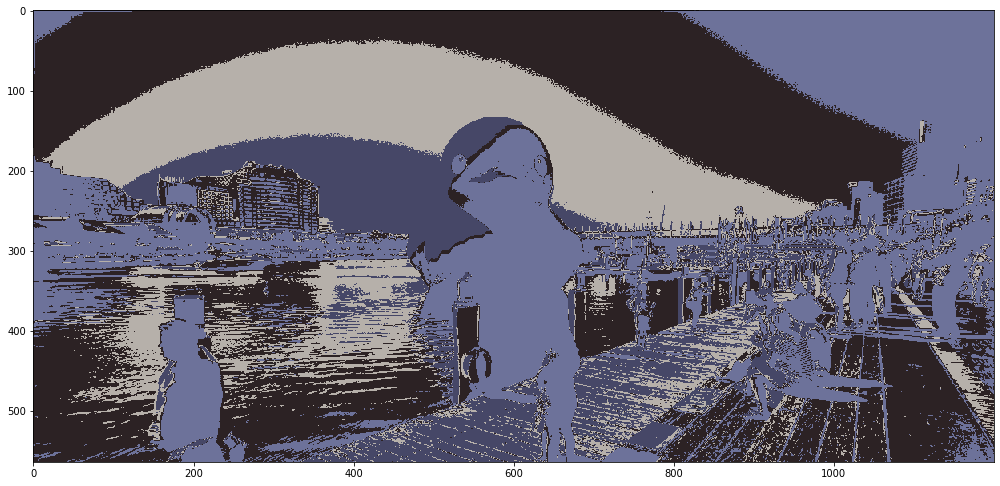

In [33]:
classes = classes.reshape(rows,cols) 
compressed_image = np.zeros((classes.shape[0], classes.shape[1],3), dtype=np.uint8)
for i in range(classes.shape[0]):
    for j in range(classes.shape[1]):
            compressed_image[i,j,:] = centroids[classes[i,j],:]
io.imshow(compressed_image)
io.show()

## Kmeans++



kmeans++ is an algorithm for choosing the initial centroids for the k-means clustering algorithm.

The idea is as follows:

1. Choose a centroid uniformly at random among the data points.
2. For each data points not chosen yet, compute the distance between the data point and the single nearest centroid that had already been chosen.
3. Choose one new data point at random as a new centroid, using a weighted probability distribution where a data point is chosen with probability proportional to the square of the distance you calculated previously. For each data point, the weight will be equal to the square distance to the closest center divided by the total squared distance (to make sure the probability adds up to 1).
4. Repeat Steps 2 and 3 until k centroids have been chosen.
5. Now that the initial centroids have been chosen, proceed using standard k-means clustering.

Inputs:
- X: a single image of shape (num_pixels, 3).
- k: number of centroids.
- p: the parameter governing the distance measure.
- max_iter: the maximum number of iterations to perform. (default value = 100).

Outputs:
- The calculated centroids as a numpy array.
- The final assignment of all RGB points to the closest centroids as a numpy array.
"""

In [ ]:
# euclidean distance
def distance(p1, p2):
    return np.sum((p1 - p2)**2)

def kmeans_pp(X, k, p ,max_iter=100):
    """
    Your implenentation of the kmeans++ algorithm.
    Inputs:
    - X: a single image of shape (num_pixels, 3).
    - k: number of centroids.
    - p: the parameter governing the distance measure.
    - max_iter: the maximum number of iterations to perform.

    Outputs:
    - The calculated centroids as a numpy array.
    - The final assignment of all RGB points to the closest centroids as a numpy array.
    """
    centroids = []

    # initialize the centroids list & a add random point
    centroids.append(X[np.random.randint(X.shape[0]), :])
    
    # k - 1 centroids loop 
    for j in range(k - 1):
         
        distances = []
        for i in range(X.shape[0]):
            point = X[i, :]
            d = sys.maxsize

            # compute distance of 'point' from each of the previously selected centroid
            for j in range(len(centroids)):
                temp = distance(point, centroids[j])
                d = min(d, temp)
            distances.append(d)
             
        # select data point with maximum distance as centroid
        distances = np.array(distances)
        new_centroid = X[np.argmax(distances), :]
        centroids.append(new_centroid)

    # convert centroids
    list_of_lists = [l.tolist() for l in centroids]
    centroids = list_of_lists
    centroids = np.asarray(centroids).astype(np.float)

    # send to K-means with centroids
    return kmeans(X, k, p ,max_iter, centroids)

In [48]:
%%time
centroids1, classes1 = kmeans_pp(image, k=4, p=1, max_iter=5)

0
[[ 38.39292102  36.61062444  56.45447665]
 [ 82.3615196   82.30687506 110.62544308]
 [116.41868568  64.3203795    3.838497  ]
 [142.93194661 142.98565353 163.1964029 ]]
1
[[ 78.28796537  81.32795407 117.19972897]
 [132.26493121  87.40990907   6.80780956]
 [150.4602294  149.99302506 169.98383946]
 [ 33.87339622  31.6885327   50.74593105]]
2
[[146.2603085   99.41867235   8.4070584 ]
 [153.96981147 152.9560882  172.09935998]
 [ 34.33459654  30.94958639  47.42501442]
 [ 78.20987976  81.65585296 118.26339543]]
3
[[155.25842361 154.08996523 173.12232717]
 [ 34.71046444  30.89585115  46.67632627]
 [ 78.46889873  81.94317746 118.68451297]
 [150.46483352 103.99625889   8.47275221]]
4
[[ 34.96263038  31.02131055  46.66063666]
 [ 78.70846462  82.21570737 119.00962778]
 [151.58340961 105.18869354   8.39509485]
 [155.82908814 154.59808579 173.50840111]]
5
[[ 78.86525467  82.39050322 119.22649793]
 [151.88196005 105.50055396   8.40299452]
 [156.15901693 154.89127376 173.7003312 ]
 [ 35.08426354  3

In [49]:
print(centroids1)
print(classes1)

[[ 79.22058288  82.78863676 119.67350265]
 [151.946089   105.56497211   8.3815606 ]
 [156.64885551 155.31124367 173.89987423]
 [ 35.31485039  31.36951268  47.13706806]]
[1 0 0 ... 0 0 0]


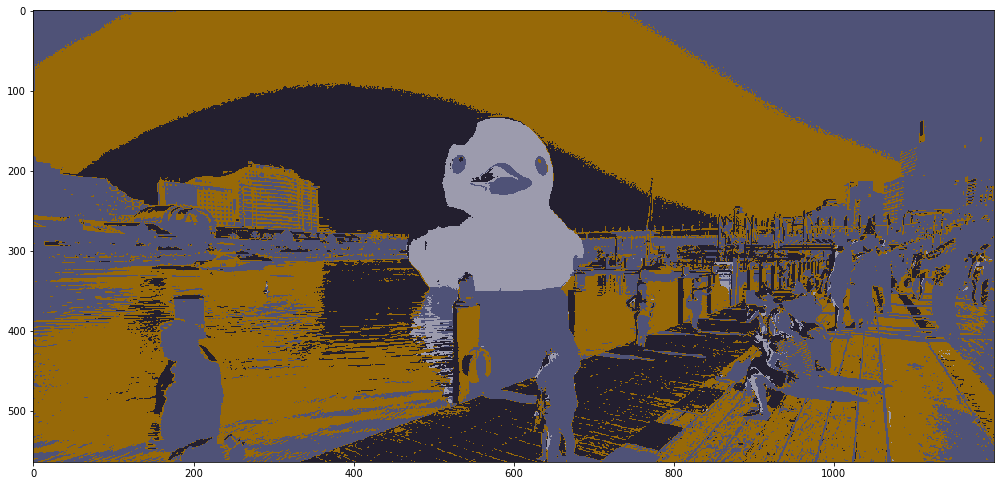

In [50]:
classes = classes1.reshape(rows,cols) 
compressed_image = np.zeros((classes.shape[0], classes.shape[1],3), dtype=np.uint8)
for i in range(classes.shape[0]):
    for j in range(classes.shape[1]):
            compressed_image[i,j,:] = centroids1[classes[i,j],:]
io.imshow(compressed_image)
io.show()

One disadvantage of the K-means algorithm is that it is sensitive to the initialization of the centroids or the mean points. So, if a centroid is initialized to be a “far-off” point, it might just end up with no points associated with it, and at the same time, more than one cluster might end up linked with a single centroid. Similarly, more than one centroids might be initialized into the same cluster resulting in poor clustering.

K-means++ is computationally more expensive than the standard K-means algorithm, the run-time for convergence to optimum is drastically reduced for K-means++. This is because the centroids that are initially chosen are likely to lie in different clusters already